In [1]:
import pandas as pd
from sqlalchemy import create_engine

# 데이터베이스 연결 설정
db_host = '192.168.0.41:5432'
db_user = 'postgres'
db_password = '1234'
db_name = 'postgres'

# 데이터베이스 연결
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}/{db_name}')

# 데이터베이스에서 데이터 가져오기
query = f"SELECT * FROM finance_data order by name, date"
df_or = pd.read_sql(query, engine)

In [2]:
# 선정된 종목들만 선택
from tqdm import tqdm
df_list = []
for name in tqdm(df_or['name'].unique()):
    df_list.append(df_or[df_or['name']==name])

100%|██████████| 2593/2593 [06:08<00:00,  7.04it/s]


Epoch 1/100
3/3 [==============================] - 2s 6ms/step - loss: 0.1446
Epoch 2/100
3/3 [==============================] - 0s 6ms/step - loss: 0.1096
Epoch 3/100
3/3 [==============================] - 0s 7ms/step - loss: 0.0967
Epoch 4/100
3/3 [==============================] - 0s 6ms/step - loss: 0.1036
Epoch 5/100
3/3 [==============================] - 0s 5ms/step - loss: 0.1079
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 0.1049
Epoch 7/100
3/3 [==============================] - 0s 7ms/step - loss: 0.1002
Epoch 8/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0979
Epoch 9/100
3/3 [==============================] - 0s 7ms/step - loss: 0.0968
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 0.0968
Epoch 11/100
3/3 [==============================] - 0s 7ms/step - loss: 0.0964
Epoch 12/100
3/3 [==============================] - 0s 7ms/step - loss: 0.0961
Epoch 13/100
3/3 [==============================] - 0s 7ms/st

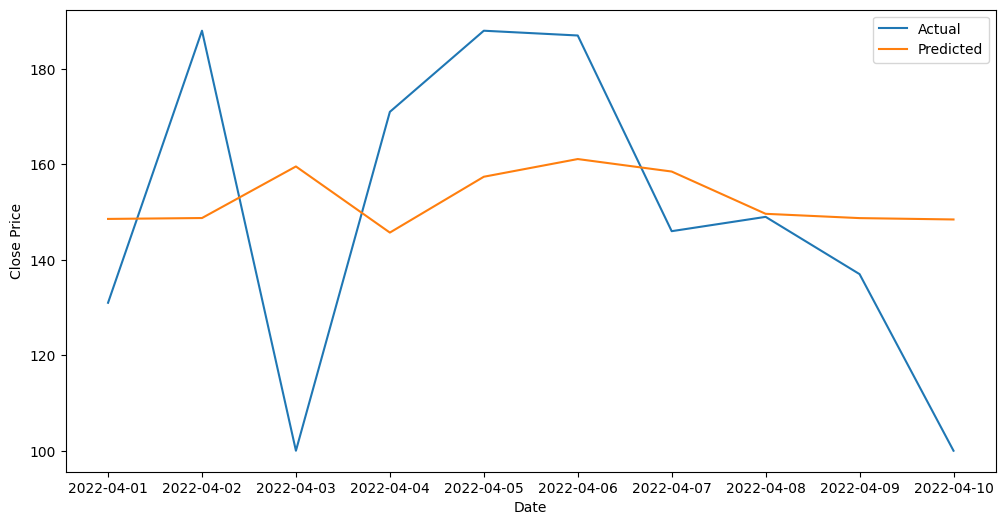

In [58]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# 주가 데이터 로드
# 주가 데이터는 Date, Open, High, Low, Close 등의 컬럼으로 구성된 데이터프레임이어야 합니다.
# 여기서는 예시로 간단한 데이터를 생성하겠습니다.
data = {
    'Date': pd.date_range(start='2022-01-01', periods=100, freq='D'),
    'Close': np.random.randint(100, 200, 100)
}
df = pd.DataFrame(data)

# 데이터 정규화
scaler = MinMaxScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

# 학습 데이터와 테스트 데이터로 분리
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# 시퀀스 데이터로 변환
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length+1]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 10
train_seq = create_sequences(train['Close'].values, seq_length)
test_seq = create_sequences(test['Close'].values, seq_length)

# 입력(X)과 출력(y) 분리
X_train, y_train = train_seq[:, :-1], train_seq[:, -1]
X_test, y_test = test_seq[:, :-1], test_seq[:, -1]

# 모델 구성
model = Sequential()
model.add(GRU(50, input_shape=(seq_length, 1)))
model.add(Dense(1, activation='linear'))

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# 테스트 데이터로 예측
y_pred = model.predict(X_test)

# 정규화 된 값을 원래 스케일로 복원
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual')
plt.plot(df['Date'][-len(y_test):], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
